In [1]:
# Load
%load_ext autoreload

from matplotlib.ticker import FuncFormatter
from scipy.stats import truncnorm, uniform
from enum import Enum
from IPython.display import display

import pandas as pd 
import wandb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
api = wandb.Api()


In [28]:


def prepare_csv(runs_df, min_scale):
    counter = 0
    new_runs = {}
    runs_df_T = runs_df.T
    for run in runs_df_T:
        
        for i in range(runs_df['dataset.nr_scales'].max()):
            temp_res = dict({}, **runs_df_T[run])
            temp_res['Test Acc'] = runs_df_T[run][f'Test Acc Class Scale {i}']
            temp_res['Test Error'] = runs_df_T[run][f'Test Error Class Scale {i}']
            # i = int(math.floor(rvs[index] * size) - min_size)
            temp_res['Scale'] = min((i + min_scale * 56), 56) / 56
            temp_res['Conv Scales'] = str( runs_df_T[run]['Conv Scales'])
            temp_res['dataset.dist_params'] = str( runs_df_T[run]['dataset.dist_params'])
            temp_res['Internal Scale Ratio'] = round(runs_df_T[run]['model.base_scale'] ** (1/3),2)
            new_runs[counter] = temp_res
            counter += 1
    new_runs_df = pd.DataFrame(new_runs)
    small = new_runs_df.T.loc[:, ['Scale','Test Acc','Test Error','model.base_scale','dataset.nr_scales','seed','model.basis_min_scale_SESN','dataset.dist_params','Conv Scales','Internal Scale Ratio']]
    return small

def prepare_api_runs(runs, values = ['test/acc'], rounding=True):
    combined = []
    for run in runs: 
        temp_info_dict = run.summary._json_dict
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        temp_info_dict.update(run.config)
        dist = temp_info_dict['sample_scales'][0].lower()
        if dist == 'loguniform':
            dist = 'log-uniform'
        dist = dist + ' '
        dist = dist.capitalize()
        temp_info_dict['Scale Distribution'] = dist + str(temp_info_dict['sample_scales'][1:])
        # temp_info_dict['Scale Distribution'] = temp_info_dict['sample_scales'][2]
        if isinstance(temp_info_dict['init_scales'], int) or isinstance(temp_info_dict['init_scales'], float):
            temp_info_dict['init_scales'] = [temp_info_dict['init_scales']]
        if rounding:
            temp_info_dict['sample_scales'] = str([round(sample_scale,3) for sample_scale in temp_info_dict['sample_scales'][1:]])
            temp_info_dict['init_scales'] = str([round(init_scale,3) for init_scale in temp_info_dict['init_scales']])

        else:
            temp_info_dict['sample_scales'] = str(temp_info_dict['sample_scales'])
            temp_info_dict['init_scales'] = str(temp_info_dict['init_scales'])
        if 'test/acc' in temp_info_dict.keys():
            temp_info_dict['Test Error'] = (1 - temp_info_dict['test/acc'])*100
            # temp_info_dict['val/acc.max'] = temp_info_dict['val/acc']['max']
            combined.append(temp_info_dict)

    return combined

def plot_table(runs_in, name, indexes = ['sample_scales','init_scales'], values = ['Test Error'], rounding = True, Save=False):
    # Prepare and load into dataframe
    all_info = prepare_api_runs(runs_in, values)
    df = pd.DataFrame.from_dict(all_info)
    # display(df)
    line_plot(df)
    plot_bar_chart_levels(df, x_label_index="Final ISR", y_axis="Test Error", dists=[[1, 2.83], [1, 4.76], [1, 8]])

    df = df.pivot_table(index=indexes, values=values, aggfunc=(np.mean, np.std))
    # Save Df
    if rounding:
        df = df.astype(float).round(3)
    display(df)
    if Save:
        df.to_csv(f'results/{name}')

def plot_bar_chart_levels(df, x_label_index, y_axis, y_limit = 3.7, dists = [[1, 2.83], [1, 4], [1, 5.65]]):


    f, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    f.suptitle("Classification Error for Various Distributions and ISR values")

    for i, dist in enumerate(dists):
        df_t = df.loc[df['sample_scales'] == str(dist)]
        g = sns.barplot(data=df_t, x=x_label_index, y=y_axis, ax=axs[i], errorbar='sd')
        g.set_ylim(0, y_limit)
        axs[i].axhline(0, color="k", clip_on=False)
        axs[i].title.set_text(f"LogUniform {dist}")
        axs[i].grid(axis='y')  #just add this



    sns.despine(bottom=True)
    plt.tight_layout(h_pad=2)

    plt.show()

def line_plot(df):
    sns.color_palette("tab10")

    # Seaborn lineplot for each ISR, X-Axis is the range of the data scale distribution
    # X-Axis is the test error with errobars
    # Y-Axis is the range of the data scale distribution
    df['ISR'] = df['Final ISR']

    df_piv = df.pivot_table(index=["Scale Distribution",'ISR'], values="Test Error", aggfunc=(np.mean, np.std))
    # Find lowest MEAN test error for each Scale Distribution over seeds
    df_piv = df_piv.loc[df_piv.groupby(level=0)['mean'].idxmin()]
    df_piv = df_piv.reset_index()
    fig, ax = plt.subplots(figsize=(10, 7))

    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams.update({'font.size': 14})
    sns.lineplot(data=df, x='ISR', y="Test Error", hue="Scale Distribution", errorbar='sd')
    best_x = []
    best_y = []
    for index, row in df_piv.iterrows():
        best_x.append(row['ISR'])
        best_y.append(row['mean'])
    plt.xscale("log", base=2)
    plt.scatter(x = best_x, y= best_y, marker="x", color="black", label="Best")
    plt.legend(title="Scale Distribution")
    plt.savefig("/home/markb/Desktop/New Results/error_ISR.pdf",
            dpi=300,
            bbox_inches='tight')
    plt.show()

    # IDEA FOR PARETTO PLOT
    # sns.lineplot(data=df_piv, x="Scale Distribution", y="Final ISR")
    # plt.show()







# New Scale Influence Experiment


## Dataset Distributions

### LogUniform

Since the Internal scale in a logarithmic manner, it made more sense to also do the same for the data distributions we use, this also makes it easier to link the internal scales to the dataset scales. That is also the reason why we, unlike SESN and DISCO, use logUniform distributions (or uniform on a logarithmic scale as Lindeberg calls them). 

For this toyexperiment we would like to have the smallest number of confounding factors possible. That is why:
- We only consider MNIST digits scaled up (since downsampling results in loss of information)
- We reduce the network to a single conv-layer with a fully connected layer in the end (following resolution learning paper)
- Only scaling up reduces our scaling factor and therefore we only consider 2 internal scales 




The scales that were chosen are such that they all fall within 1 and 6.0, the octaves that were used were calculated using $[\text{lowest\_scale} * 2^{(1.5 + 0.5*i)} \text{ for } i \text{ in range(3)}]$ 

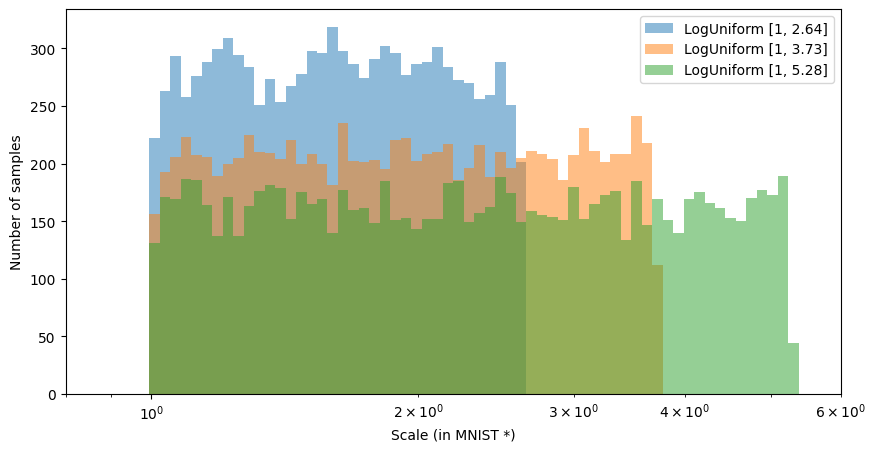

### LogNormal (Later)

Since we claim that data scales are also viewed as logarithmic it makes the most sense to look at logNormal distributions as well. 
Let's set the mean of the lognormal on 1.0 (as this is exactly 1 octave above 0.5 and below 2), which is mostly our working range.

Based on the chosen mean and std we calculate the necessary parameters such that the lognormal distribution reflect this mean and std.



## Internal Scales
The Internal Scales will follow the parameterization used in DISCO and SESN:
$[\text{basis\_min\_sigma}\times {p^{(\frac{1}{N-1})^i}} \text{ for } i \text{ in }{0..N-1} ]$.

With:
- Basis\_min\_sigma = 1.5
- N = 3
  
and we vary p (ISR) between 1.5 and 6.  




### Hypothesis


We believe each filter at a certain inner scale has a certain tolerance to which data
scales it will activate on.

We expect:
- ISR must overlap with the data scale distribution
- ISR should be small enough as to not lose generalization between filters of subsequent scales. 
- ISR should be a little smaller than the actual range of the data scale distribution (tolerance argument)


## Results

### Commands to run evaluation

In [21]:
#### CODE TO DETERMINE IDS TO STILL TEST EXTENSIVELY

import math


api = wandb.Api()
exp_name = 'LogUniform_exp_4'
exp_group = 'scale_influence_2'
artifact_project = 'scale_influence_2'

# exp_name = 'scale_learning_1'
# exp_group = 'scale_learning'
# artifact_project = 'scale_learning'

runs = api.runs(f"mbasting/{exp_group}", {
    "$and": [{"tags" :  exp_name}, {"config.ISR_start" : {"$in" : [6]}}, {"$not": {"tags" :  'Test Extensively'}}] #, {"$not": {"config.ISR_start" : 1.71}}
})

runs_tested = api.runs(f"mbasting/{exp_group}", {
    "$and": [{"tags" :  exp_name},  {"tags" : 'Test Extensively'}]
})

# ordered_runs  = sorted(runs, key=lambda run: run.config['seed'])
samples_scales = set([str(run.config['sample_scales']) for run in runs])
run_ids_tested = [run.config['run_id'] for run in runs_tested if 'run_id' in run.config.keys()]

# Separate runs based on sample_scales
for sample_scale in samples_scales:
    runs_grouped = [run for run in runs if str(run.config['sample_scales']) == sample_scale]
    ordered_runs_grouped  = sorted(runs_grouped, key=lambda run: run.config['seed'])
    run_ids = [run.id for run in ordered_runs_grouped]
    todo = [run_id for run_id in run_ids if run_id not in run_ids_tested]
    if len(todo) > 0:
        todo_str = ','.join(str(i) for i in todo)
        print(f"python sl_generate_sweep.py test_multiple shared.reuse_train_mean_std=True shared.entity=mbasting shared.project={exp_group} shared.tags=[\'{exp_name}\',\'Test Extensively\','reuse_mean_train'] shared.in_depth=True shared.cluster=False shared.nr_workers=8 var.run_ids=[{todo_str}] shared.artifact_project={artifact_project} shared.cutoff=[0.5,11.314]; ")


### Experiment 1
What's so special about this experiment?
- Single Layer + FC
- hermite_a
- P => [1.5, 1.75, 2.04, 2.38, 2.78, 3.24, 3.78, 4.40, 5.14, 6]
- N = 3
- LogUniform Data Distributions: [1.0, 2.83], [1.0, 4], [1.0, 5.65]
- Img_size = 160 (~28 * 5.65)
- Largest kernel size (based on base_kernel size ~ 7, factor 10): 71

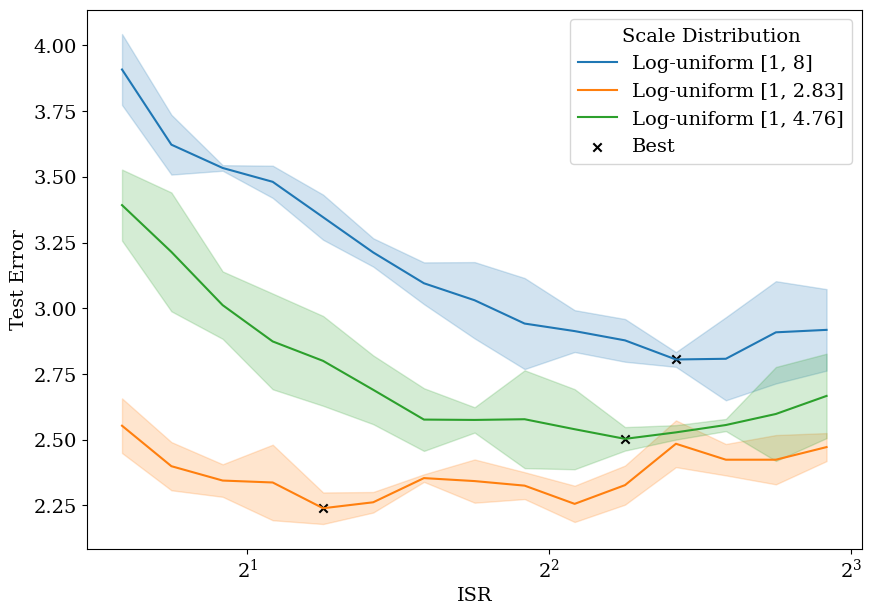

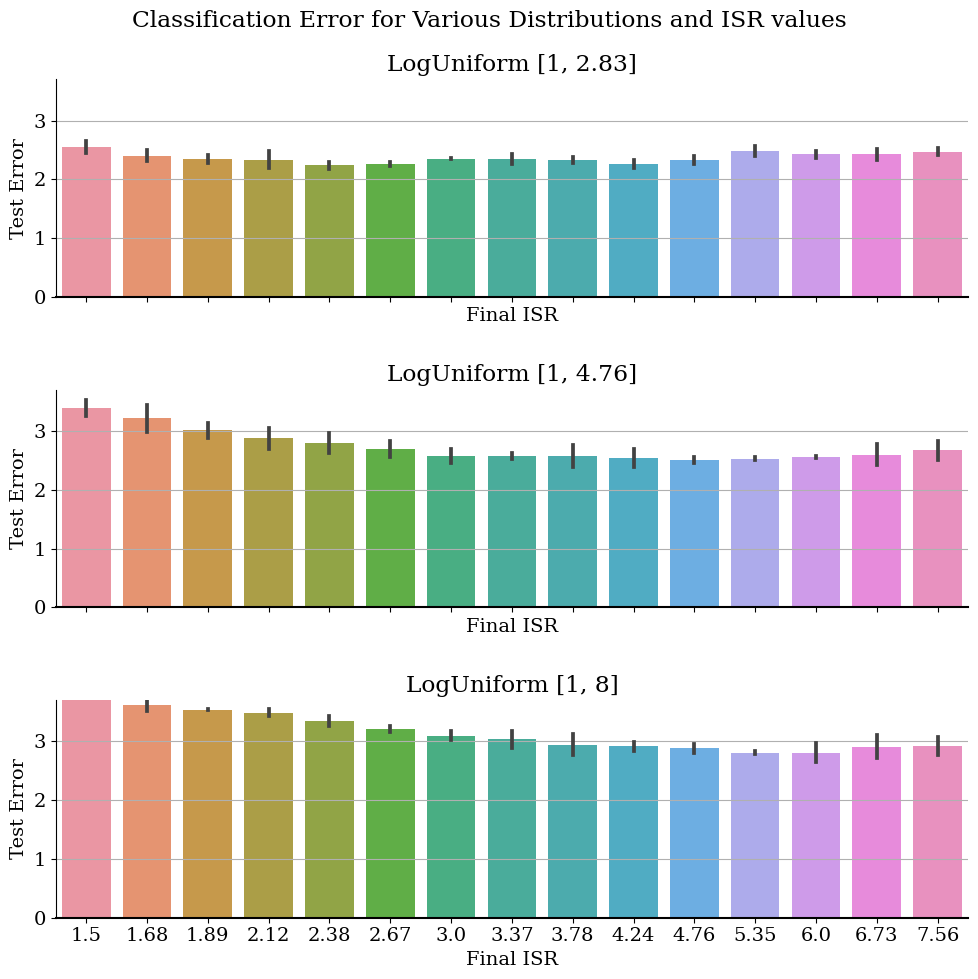

Test Error       
                                mean    std
sample_scales init_scales                  
[1, 2.83]     [1.5]            2.553  0.104
              [1.68]           2.399  0.092
              [1.89]           2.345  0.062
              [2.12]           2.337  0.144
              [2.38]           2.239  0.060
              [2.67]           2.262  0.039
              [3.37]           2.343  0.082
              [3.78]           2.325  0.051
              [3]              2.354  0.014
              [4.24]           2.256  0.069
              [4.76]           2.327  0.074
              [5.35]           2.485  0.089
              [6.73]           2.424  0.094
              [6]              2.424  0.060
              [7.56]           2.472  0.053
[1, 4.76]     [1.5]            3.393  0.135
              [1.68]           3.215  0.226
              [1.89]           3.012  0.128
              [2.12]           2.874  0.182
              [2.38]           2.800  0.171
              [2.67]           2.690  0.131
              [3.37]           2.575  0.048
              [3.78]           2.578  0.186
              [3]              2.577  0.119
              [4.24]           2.540  0.152
              [4.76]           2.503  0.045
              [5.35]           2.528  0.027
              [6.73]           2.598  0.179
              [6]              2.556  0.023
              [7.56]           2.667  0.161
[1, 8]        [1.5]            3.909  0.135
              [1.68]           3.623  0.114
              [1.89]           3.534  0.011
              [2.12]           3.481  0.061
              [2.38]           3.347  0.086
              [2.67]           3.213  0.054
              [3.37]           3.031  0.145
              [3.78]           2.942  0.173
              [3]              3.095  0.079
              [4.24]           2.913  0.080
              [4.76]           2.878  0.081
              [5.35]           2.805  0.028
              [6.73]           2.909  0.195
              [6]              2.808  0.158
              [7.56]           2.918  0.155

In [29]:
### Visualize Results

%autoreload
api = wandb.Api()

runs = api.runs(f"mbasting/scale_influence_2", {
    "$and": [{"tags": "LogUniform_exp_4"}, {"$not" : {"tags": "Test Extensively"}}] # {"$not" : 
})

if len(runs) > 0:
    plot_table(runs, None, rounding=True, Save=False)
else:
    print("No runs found")


    


#### Scale Learning Results

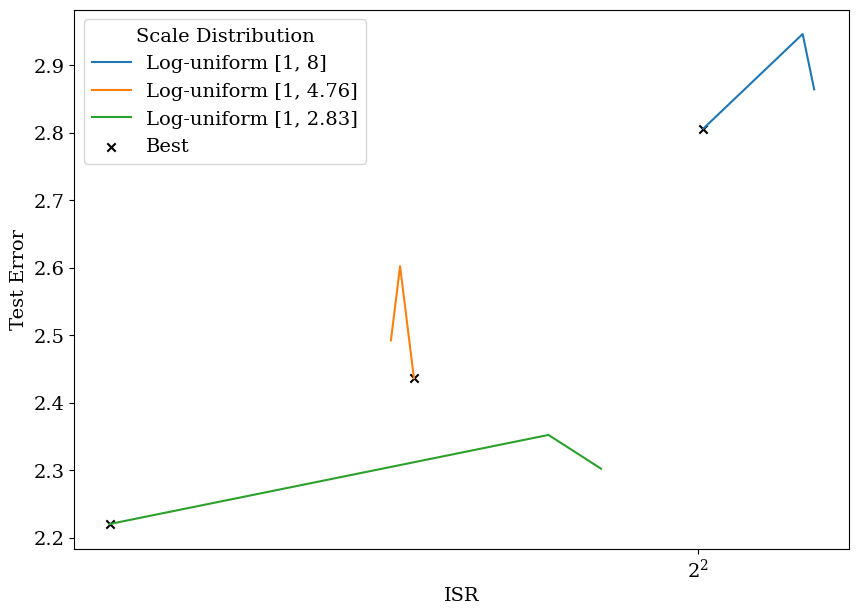

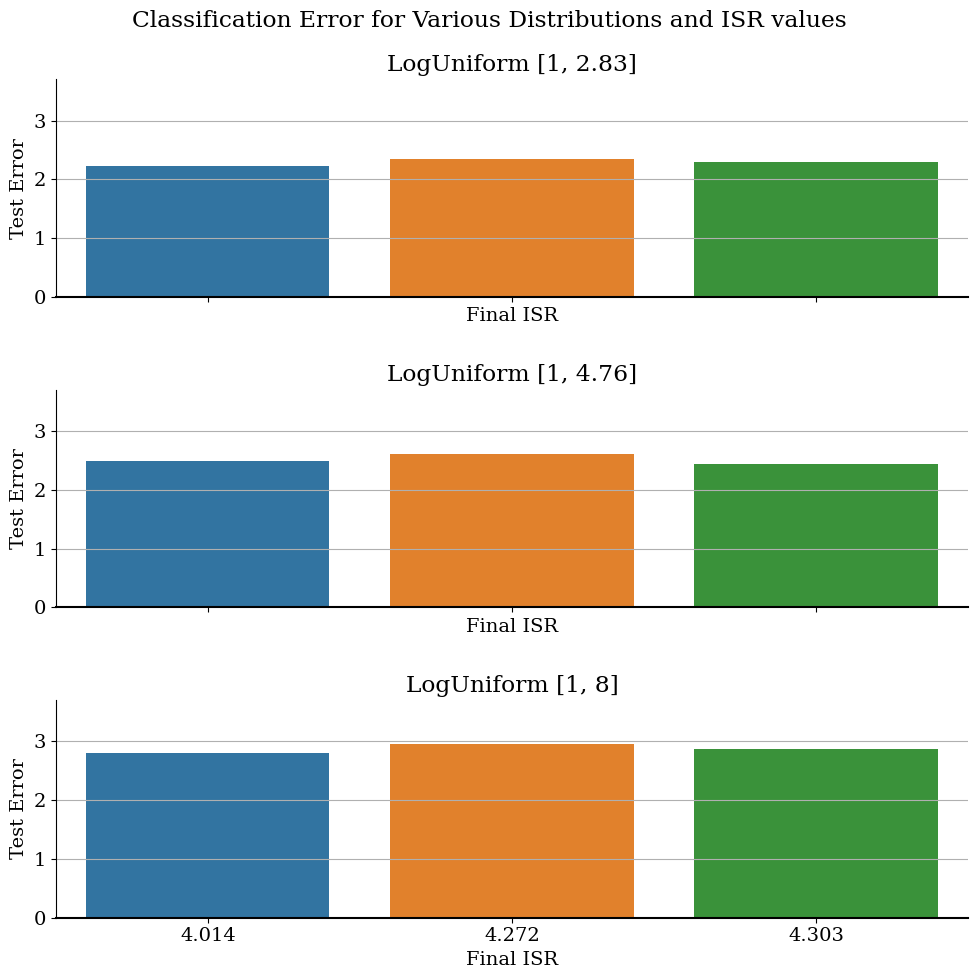

Test Error       
                                mean    std
sample_scales init_scales                  
[1, 2.83]     [3]              2.291  0.067
[1, 4.76]     [3]              2.510  0.084
[1, 8]        [3]              2.872  0.070

In [35]:
runs = api.runs(f"mbasting/scale_learning", {
    "$and": [{"tags": "scale_learning_16"}]
})
if len(runs) > 0:
    plot_table(runs, None, rounding=True, Save=False)
else:
    print("No runs found")

#### Accuracy per scale plots


In [33]:
def prepare_csv_Acc_scale(runs, rounding=False, nr_scales = 45):
    counter = 0
    new_runs = {}
    # How do we get back range of scale?
    # For now: hardcode
    for run in runs:
        scales = np.logspace(-1, 3.5, nr_scales, base=2)        
        for i in range(nr_scales):
            temp_info_dict = {}
            # temp_info_dict = run.summary._json_dict
            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files 
            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            temp_info_dict['ISR'] = run.config['ISR_start']
            temp_info_dict['ISR'] = run.config['Final ISR']
            temp_info_dict['seed'] = run.config['seed']
            temp_info_dict['Basis Min Scale'] = run.config['basis_min_scale']
            temp_info_dict['Learned Basis Min Scale'] = run.config['Final Basis Min Scale']
            temp_info_dict['Data Scale Boundaries'] = run.config['sample_scales'][1:]
            data_scale_dist_name = run.config['sample_scales'][0].lower()
            if data_scale_dist_name == 'loguniform':
                data_scale_dist_name = 'log-uniform'
            
            temp_info_dict['Data Scale Distribution'] = f"{data_scale_dist_name.capitalize()} {run.config['sample_scales'][1:]}"
            # if isinstance(temp_info_dict['init_scales'], int) or isinstance(temp_info_dict['init_scales'], float):
            #     temp_info_dict['init_scales'] = [temp_info_dict['init_scales']]
            # if rounding:
            #     temp_info_dict['sample_scales'] = str([round(sample_scale,3) for sample_scale in temp_info_dict['sample_scales'][1:]])
            #     temp_info_dict['init_scales'] = str([round(init_scale,3) for init_scale in temp_info_dict['init_scales']])

            # else:
            #     temp_info_dict['sample_scales'] = str(temp_info_dict['sample_scales'])
            #     temp_info_dict['init_scales'] = str(temp_info_dict['init_scales'])

            temp_info_dict['Test Acc'] = run.summary[f'test/acc scale {i}']
            temp_info_dict['Test Error'] = 1 - run.summary[f'test/acc scale {i}']
            # i = int(math.floor(rvs[index] * size) - min_size)
            temp_info_dict['Scale Factor of Original MNIST'] = scales[i]
            new_runs[counter] = temp_info_dict
            counter += 1
    new_runs_df = pd.DataFrame(new_runs)
    # display(new_runs_df)
    # small = new_runs_df.T.loc[:, ['Scale','Test Acc','Test Error','model.base_scale','dataset.nr_scales','seed','model.basis_min_scale_SESN','dataset.dist_params','Conv Scales','Internal Scale Ratio']]
    return new_runs_df.T, scales

def visualize_error_per_scale(runs_df, boundary_left, boundary_right):

    # Make subplots
    fig, axs = plt.subplots(1, len(runs_df['Data Scale Distribution'].unique()), figsize=(20, 6), sharey=False)

    # fig.suptitle("Classification Error per scale for Various Distributions and ISR values")
    
    for i, dist in enumerate(sorted(runs_df['Data Scale Distribution'].unique())):
        df_t = runs_df[runs_df['Data Scale Distribution'] == dist]
        # print("MAKE SURE THAT all runs have the same distribution")
        # plot acc per scale
        isrs = df_t['ISR'].unique()
        import numpy as np
        isrs.sort()
        indices = [i for i in range(len(isrs)) if i % 2 != 0]
        isrs = np.delete(isrs, indices)
        isrs.sort() 
        isrs = isrs.tolist()
        isrs.append(7.56)
        
        df_t = df_t[df_t['ISR'].isin(isrs)]

        sns.lineplot(data=df_t, x='Scale Factor of Original MNIST', y='Test Error', hue='ISR', errorbar='sd', ax=axs[i], legend='full')
        name = f'{df_t.iloc[0]["Data Scale Distribution"]}' # Error per Scale for different internal Scale Ratios \n 
        axs[i].set_title(name)
        display(df_t.iloc[0]['Data Scale Boundaries'])
        plt.xlim(boundary_left, boundary_right)
        axs[i].set_yscale('log', base=2)
        axs[i].set_xscale('log', base=2)
        isrs = df_t['ISR'].unique()
        # Remove every other ISR value from legend
        
        if i == 0:
            axs[i].legend(loc='lower right', title="ISR")
        else:
            axs[i].legend([],[], frameon=False)
        axs[i].axvline(df_t.iloc[0]['Data Scale Boundaries'][0], clip_on=False)
        axs[i].axvline(df_t.iloc[0]['Data Scale Boundaries'][1], clip_on=False)


        # ax2=ax.twinx()
        # print()
        # counts, bins = np.histogram(sampled_scales, bins=np.logspace(np.log2(boundary_left), np.log2(boundary_right), len(sampled_scales), base=2))
        # ax2.stairs(counts, bins, alpha=0.2, fill=True)
        # ax2.set_ylabel("Counts")

        # plt.savefig(f'../results/new/Large/Error_p_Scale_{dist}_{a, b}_Large.png', dpi=300, bbox_inches='tight')
    plt.savefig("/home/markb/Desktop/New Results/error_per_scale_ISR.pdf",
                dpi=300,
                bbox_inches='tight')
    plt.show()

[1, 2.83]

[1, 4.76]

[1, 8]

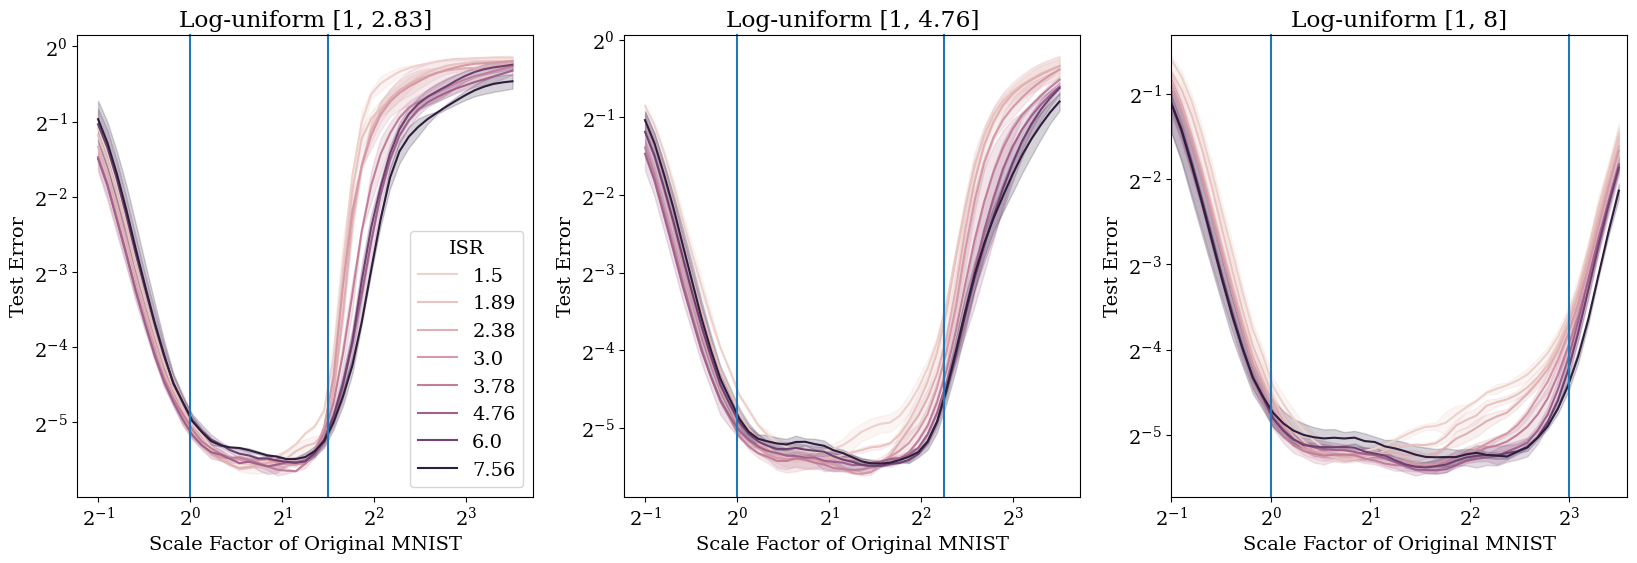

In [34]:
%autoreload
api = wandb.Api()

runs = api.runs(f"mbasting/scale_influence_2", {
    "$and": [{"tags": "LogUniform_exp_4"}, {"tags": "Test Extensively"}]
})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({'font.size': 14})


run_t1, sampled_scales = prepare_csv_Acc_scale(runs, rounding=False)
# display(run_t1[run_t1['Data Scale Distribution'] == data_scale_boundaries])
visualize_error_per_scale(run_t1, 0.5, 12)
